In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns
import scipy.signal as sig
from scipy.spatial.distance import pdist
import scikit_posthocs as sp
#import pingouin as pg
from scipy import stats
from scipy.stats import friedmanchisquare

In [2]:
input_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials'
output_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials/Phase Synchronization'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
cfa_mice = ['2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

48

In [31]:
# COMPUTE PHASE VARIANCES FOR CONCATENATED MODALITY REPLICATES
session_names = []
phase_variances = []
for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    clusters = pd.DataFrame()
    clusters['cell'] = cell_ids[:-1]
    
    for s in stimuli:
        modality_phase = pd.DataFrame()
        modality = cells[cells['identifier'].str.contains(str((s)))]
        trials = modality['identifier'].unique()
        
        for cid in cell_ids[:-1]:
            trace = modality[cid]
            trace_hill=sig.hilbert(trace)
            phase_trace=np.unwrap(np.angle(trace_hill))
            modality_phase[cid] = phase_trace
        
        modality_phase['phase_variance'] = modality_phase.var(axis=1)
        mean_phase_var = modality_phase['phase_variance'].mean()
        mean_phase_dist = np.mean(pdist(modality_phase.T))
        phase_variances.append([ses_name, s, mean_phase_var, mean_phase_dist])
            
cols = ['session', 'modality', 'mean phase variance', 'mean phase distance']
phase_vars_dist = pd.DataFrame(phase_variances, columns=cols)
phase_vars_dist.to_csv(os.path.join(output_path, 'phase variances_distances.csv'))

processing:  dF_F0_SHORT_2P06_Ses01.csv
2P06_Ses01
processing:  dF_F0_SHORT_2P06_Ses02.csv
2P06_Ses02
processing:  dF_F0_SHORT_2P06_Ses03.csv
2P06_Ses03
processing:  dF_F0_SHORT_2P05_Ses04.csv
2P05_Ses04
processing:  dF_F0_SHORT_2P06_Ses04.csv
2P06_Ses04
processing:  dF_F0_SHORT_2P06_Ses05.csv
2P06_Ses05
processing:  dF_F0_SHORT_2P05_Ses06.csv
2P05_Ses06
processing:  dF_F0_SHORT_2P06_Ses06.csv
2P06_Ses06
processing:  dF_F0_SHORT_2P05_Ses07.csv
2P05_Ses07
processing:  dF_F0_SHORT_2P06_Ses07.csv
2P06_Ses07
processing:  dF_F0_SHORT_2P07_Ses01.csv
2P07_Ses01
processing:  dF_F0_SHORT_2P08_Ses01.csv
2P08_Ses01
processing:  dF_F0_SHORT_2P07_Ses03.csv
2P07_Ses03
processing:  dF_F0_SHORT_2P08_Ses02.csv
2P08_Ses02
processing:  dF_F0_SHORT_2P07_Ses04.csv
2P07_Ses04
processing:  dF_F0_SHORT_2P07_Ses05.csv
2P07_Ses05
processing:  dF_F0_SHORT_2P08_Ses04.csv
2P08_Ses04
processing:  dF_F0_SHORT_2P07_Ses06.csv
2P07_Ses06
processing:  dF_F0_SHORT_2P08_Ses05.csv
2P08_Ses05
processing:  dF_F0_SHORT_2P07_S

In [3]:
phase_vars = pd.read_csv(os.path.join(output_path, 'phase variances.csv'), index_col=0)
phase_vars['mouse'] = phase_vars['session'].apply(lambda x: x[:4])
phase_vars['cfa'] = phase_vars['session'].apply(lambda x: 'cfa' if 'CFA' in x else 'health')
phase_vars_cfa_mice = phase_vars.loc[phase_vars['mouse'].isin(cfa_mice)]
phase_vars_cfa_mice

,session,modality,mean phase variance,mouse,cfa
80,2P07_Ses01,warm,16.928938,2P07,health
81,2P07_Ses01,hot,17.342790,2P07,health
82,2P07_Ses01,opto,10.986269,2P07,health
83,2P07_Ses01,off-target,11.063705,2P07,health
84,2P07_Ses01,von frey,22.074533,2P07,health
...,...,...,...,...,...
323,2P11_CFA,off-target,18.971971,2P11,cfa
324,2P11_CFA,von frey,19.852202,2P11,cfa
325,2P11_CFA,pin-prick,19.961710,2P11,cfa
326,2P11_CFA,approach,19.094480,2P11,cfa


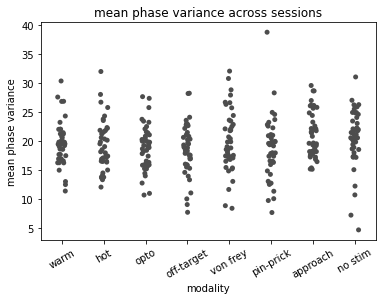

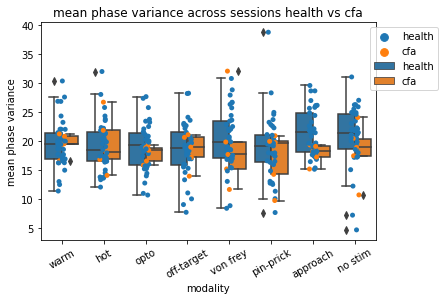

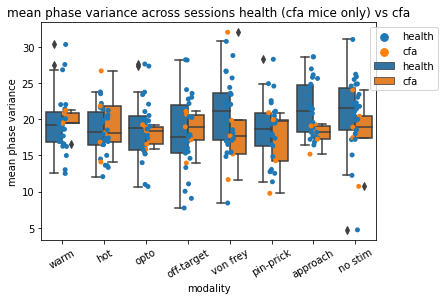

In [4]:
ax = sns.stripplot(x='modality', y='mean phase variance', data=phase_vars, color=".3")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(title='mean phase variance across sessions')
plt.savefig(os.path.join(output_path, 'phase_var.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='mean phase variance', hue='cfa', data=phase_vars)
ax = sns.boxplot(x='modality', y='mean phase variance', hue='cfa', data=phase_vars)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(title='mean phase variance across sessions health vs cfa')
ax.legend(bbox_to_anchor= (1.2,1))
plt.savefig(os.path.join(output_path, 'phase_var_health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='mean phase variance', hue='cfa', data=phase_vars_cfa_mice)
ax = sns.boxplot(x='modality', y='mean phase variance', hue='cfa', data=phase_vars_cfa_mice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set(title='mean phase variance across sessions health (cfa mice only) vs cfa')
plt.savefig(os.path.join(output_path, 'phase_var_health_cfa_cfamiceonly.png'), bbox_inches='tight')
plt.show()



In [6]:
from scipy.stats import mannwhitneyu

# approach cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='approach')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='approach')]

U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole tripicate) approach ', U1, p)
    
# no stim cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='no stim')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='no stim')]    
U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole triplicate) no stim ', U1, p)

# warm cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='warm')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='warm')]    
U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole triplicate) warm ', U1, p)

# hot cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='hot')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='hot')]    
U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole triplicate) hot ', U1, p)

# opto cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='opto')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='opto')]    
U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole triplicate) opto ', U1, p)

# off-target cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='off-target')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='off-target')]    
U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole triplicate) off-target ', U1, p)

# von frey cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='von frey')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='von frey')]    
U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole triplicate) von frey ', U1, p)

# pin-prick cfa vs health
cfa = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='cfa')& (phase_vars_cfa_mice['modality']=='pin-prick')]
health = phase_vars_cfa_mice.loc[(phase_vars_cfa_mice['cfa']=='health')& (phase_vars_cfa_mice['modality']=='pin-prick')]    
U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('phase variance (whole triplicate) pin-prick ', U1, p)


phase variance (whole tripicate) approach  97.0 0.09124777089181983
phase variance (whole triplicate) no stim  87.0 0.25706399232539384
phase variance (whole triplicate) warm  55.0 0.6202894456509583
phase variance (whole triplicate) hot  56.0 0.657756119380146
phase variance (whole triplicate) opto  74.0 0.657756119380146
phase variance (whole triplicate) off-target  61.0 0.8555302481887574
phase variance (whole triplicate) von frey  81.0 0.41681821659574714
phase variance (whole triplicate) pin-prick  72.0 0.7350318696258629


In [7]:
phase_vars_dist = pd.read_csv(os.path.join(output_path, 'phase variances_distances.csv'), index_col=0)
phase_vars_dist['mouse'] = phase_vars_dist['session'].apply(lambda x: x[:4])
phase_vars_dist['cfa'] = phase_vars_dist['session'].apply(lambda x: 'cfa' if 'CFA' in x else 'health')
phase_vars_dist_cfa_mice = phase_vars_dist.loc[phase_vars['mouse'].isin(cfa_mice)]
phase_vars_dist_cfa_mice

,session,modality,mean phase variance,mean phase distance,mouse,cfa
80,2P07_Ses01,warm,16.928938,29.838256,2P07,health
81,2P07_Ses01,hot,17.342790,37.809438,2P07,health
82,2P07_Ses01,opto,10.986269,28.243662,2P07,health
83,2P07_Ses01,off-target,11.063705,23.883523,2P07,health
84,2P07_Ses01,von frey,22.074533,49.849974,2P07,health
...,...,...,...,...,...,...
323,2P11_CFA,off-target,18.971971,39.934733,2P11,cfa
324,2P11_CFA,von frey,19.852202,40.476624,2P11,cfa
325,2P11_CFA,pin-prick,19.961710,39.319518,2P11,cfa
326,2P11_CFA,approach,19.094480,39.173491,2P11,cfa


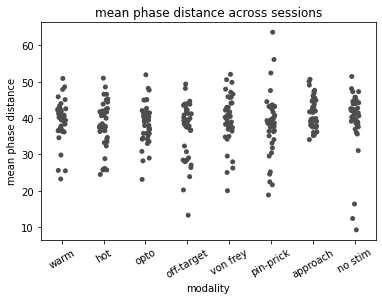

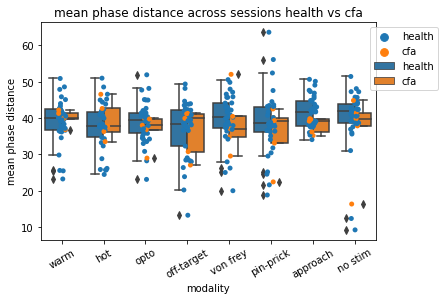

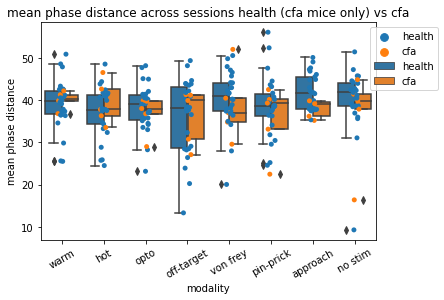

In [8]:
#Plot phase distances health vs cfa (concatenated replicates)

ax = sns.stripplot(x='modality', y='mean phase distance', data=phase_vars_dist, color=".3")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(title='mean phase distance across sessions')
plt.savefig(os.path.join(output_path, 'phase_dist.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='mean phase distance', hue='cfa', data=phase_vars_dist)
ax = sns.boxplot(x='modality', y='mean phase distance', hue='cfa', data=phase_vars_dist)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.set(title='mean phase distance across sessions health vs cfa')
ax.legend(bbox_to_anchor= (1.2,1))
plt.savefig(os.path.join(output_path, 'phase_dist_health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='mean phase distance', hue='cfa', data=phase_vars_dist_cfa_mice)
ax = sns.boxplot(x='modality', y='mean phase distance', hue='cfa', data=phase_vars_dist_cfa_mice)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set(title='mean phase distance across sessions health (cfa mice only) vs cfa')
plt.savefig(os.path.join(output_path, 'phase_dist_health_cfa_cfamiceonly.png'), bbox_inches='tight')
plt.show()

In [9]:
from scipy.stats import mannwhitneyu

# approach cfa vs health
cfa = phase_vars_dist_cfa_mice.loc[(phase_vars_dist_cfa_mice['cfa']=='cfa')& (phase_vars_dist_cfa_mice['modality']=='approach')]
health = phase_vars_dist_cfa_mice.loc[(phase_vars_dist_cfa_mice['cfa']=='health')& (phase_vars_dist_cfa_mice['modality']=='approach')]

U1, p = mannwhitneyu(np.array(health['mean phase distance']), np.array(cfa['mean phase distance']))
print('phase distance (whole triplicate) approach ', U1, p)
    
# no stim cfa vs health
cfa = phase_vars_dist_cfa_mice.loc[(phase_vars_dist_cfa_mice['cfa']=='cfa')& (phase_vars_dist_cfa_mice['modality']=='no stim')]
health = phase_vars_dist_cfa_mice.loc[(phase_vars_dist_cfa_mice['cfa']=='health')& (phase_vars_dist_cfa_mice['modality']=='no stim')]    
U1, p = mannwhitneyu(np.array(health['mean phase distance']), np.array(cfa['mean phase distance']))
print('phase distance (whole triplicate) no stim ', U1, p)

# von frey cfa vs health
cfa = phase_vars_dist_cfa_mice.loc[(phase_vars_dist_cfa_mice['cfa']=='cfa')& (phase_vars_dist_cfa_mice['modality']=='von frey')]
health = phase_vars_dist_cfa_mice.loc[(phase_vars_dist_cfa_mice['cfa']=='health')& (phase_vars_dist_cfa_mice['modality']=='von frey')]    
U1, p = mannwhitneyu(np.array(health['mean phase distance']), np.array(cfa['mean phase distance']))
print('phase distance (whole triplicate) von frey ', U1, p)



phase distance (whole triplicate) approach  97.0 0.09124777089181983
phase distance (whole triplicate) no stim  81.0 0.41681821659574714
phase distance (whole triplicate) von frey  80.0 0.44791685058648345


In [8]:
# COMPUTE PHASE VARIANCES PRE & POST STIMULUS
session_names = []
phase_variances = []
for session in [sessions[10]]:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue
    if session.endswith('2P05_Ses01.csv'): # excluding for the time being incomplete sessions (half-sessions)
        continue
    if session.endswith('2P05_Ses02.csv'):
        continue
    if session.endswith('2P07_Ses02.csv'):
        continue
    if session.endswith('2P11_Ses03.csv'):
        continue
    if session.endswith('2P08_Ses03.csv'): # doens't have opto trials ...
        continue
    
    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    clusters = pd.DataFrame()
    clusters['cell'] = cell_ids[:-1]
    
    for s in stimuli:
        pre_phase = pd.DataFrame()
        post_phase = pd.DataFrame()
        pre = pd.DataFrame()
        post = pd.DataFrame()
        modality = cells[cells['identifier'].str.contains(str((s)))]
        trials = modality['identifier'].unique()
        
        for t in trials:
            trial = modality[modality['identifier']==t]
            preS = trial[:10]
            pre = pd.concat([pre, preS])
            postS = trial[10:]
            post = pd.concat([post, postS])
        
        for cid in cell_ids[:-1]:
            pre_trace = pre[cid]
            pre_trace_hill=sig.hilbert(pre_trace)
            pre_phase_trace=np.unwrap(np.angle(pre_trace_hill))
            pre_phase[cid] = pre_phase_trace
        
        mean_pre_d = np.mean(pdist(pre_phase.T))
        pre_phase['phase_variance'] = pre_phase.var(axis=1)
        mean_pre_var = pre_phase['phase_variance'].mean()
        phase_variances.append([ses_name, s, 'pre', mean_pre_var, mean_pre_d])
        
        for cid in cell_ids[:-1]:
            post_trace = post[cid]
            post_trace_hill=sig.hilbert(post_trace)
            post_phase_trace=np.unwrap(np.angle(post_trace_hill))
            post_phase[cid] = post_phase_trace
        
        mean_post_d = np.mean(pdist(post_phase.T))
        post_phase['phase_variance'] = post_phase.var(axis=1)
        mean_post_var = post_phase['phase_variance'].mean()
        phase_variances.append([ses_name, s, 'post', mean_post_var, mean_post_d])
            
cols = ['session', 'modality', 'pre/post', 'mean phase variance', 'mean phase distance']
phase_vars = pd.DataFrame(phase_variances, columns=cols)
phase_vars.to_csv(os.path.join(output_path, 'phase variances pre_post.csv'))


processing:  dF_F0_SHORT_2P06_Ses01.csv


/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


processing:  dF_F0_SHORT_2P06_Ses02.csv
processing:  dF_F0_SHORT_2P06_Ses03.csv
processing:  dF_F0_SHORT_2P05_Ses04.csv
processing:  dF_F0_SHORT_2P06_Ses04.csv
processing:  dF_F0_SHORT_2P06_Ses05.csv
processing:  dF_F0_SHORT_2P05_Ses06.csv
processing:  dF_F0_SHORT_2P06_Ses06.csv
processing:  dF_F0_SHORT_2P05_Ses07.csv
processing:  dF_F0_SHORT_2P06_Ses07.csv
processing:  dF_F0_SHORT_2P07_Ses01.csv
processing:  dF_F0_SHORT_2P08_Ses01.csv
processing:  dF_F0_SHORT_2P07_Ses03.csv
processing:  dF_F0_SHORT_2P08_Ses02.csv
processing:  dF_F0_SHORT_2P07_Ses04.csv
processing:  dF_F0_SHORT_2P07_Ses05.csv
processing:  dF_F0_SHORT_2P08_Ses04.csv
processing:  dF_F0_SHORT_2P07_Ses06.csv
processing:  dF_F0_SHORT_2P08_Ses05.csv
processing:  dF_F0_SHORT_2P07_Ses07.csv
processing:  dF_F0_SHORT_2P08_Ses06.csv
processing:  dF_F0_SHORT_2P07_CFA.csv
processing:  dF_F0_SHORT_2P09_Ses01.csv
processing:  dF_F0_SHORT_2P08_CFA.csv
processing:  dF_F0_SHORT_2P11_Ses01.csv
processing:  dF_F0_SHORT_2P10_Ses01.csv
proc

In [10]:
phase_vars = pd.read_csv(os.path.join(output_path, 'phase variances pre_post.csv'), index_col=0)
health = phase_vars.loc[phase_vars['session'].str.contains('Ses')]
cfa = phase_vars.loc[phase_vars['session'].str.contains('CFA')]
health

,session,modality,pre/post,mean phase variance,mean phase distance
0,2P06_Ses01,warm,pre,12.274994,22.105924
1,2P06_Ses01,warm,post,10.051329,18.458336
2,2P06_Ses01,hot,pre,9.781513,19.817575
3,2P06_Ses01,hot,post,8.664389,16.415189
4,2P06_Ses01,opto,pre,11.527578,20.920703
...,...,...,...,...,...
667,2P05_Ses03,pin-prick,post,5.276168,12.197500
668,2P05_Ses03,approach,pre,7.287268,16.201324
669,2P05_Ses03,approach,post,8.647591,16.888042
670,2P05_Ses03,no stim,pre,13.158730,23.097975


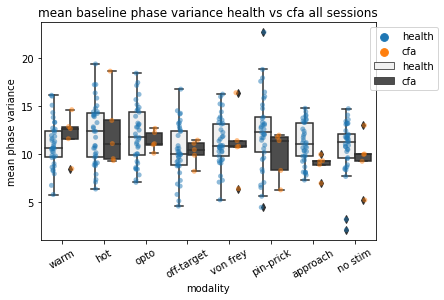

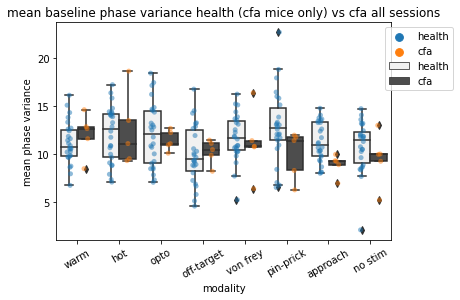

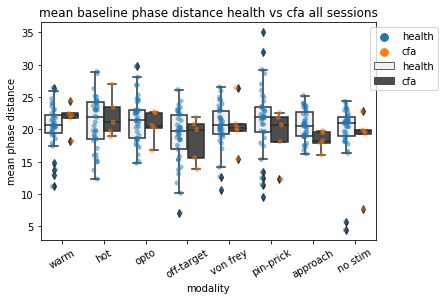

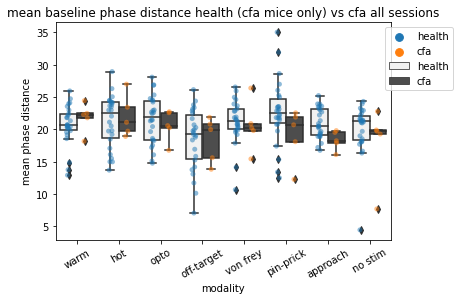

In [11]:
# Focus on baseline only to compare health vs cfa
phase_vars['mouse'] = phase_vars['session'].apply(lambda x: x[:4])
phase_vars['cfa'] = phase_vars['session'].apply(lambda x: 'cfa' if 'CFA' in x else 'health')
phase_vars_pre = phase_vars.loc[phase_vars['pre/post']=='pre']
phase_vars_pre_cfa_mice = phase_vars_pre.loc[phase_vars_pre['mouse'].isin(cfa_mice)]

ax = sns.stripplot(x="modality", y="mean phase variance", hue="cfa", data=phase_vars_pre, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase variance", hue="cfa", data=phase_vars_pre, color='.3')
#ax.legend([],[], frameon=False)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean baseline phase variance health vs cfa all sessions')
plt.savefig(os.path.join(output_path, 'baseline phase variance all sessions health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="mean phase variance", hue="cfa", data=phase_vars_pre_cfa_mice, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase variance", hue="cfa", data=phase_vars_pre_cfa_mice, color='.3')
#ax.legend([],[], frameon=False)
ax.legend(bbox_to_anchor= (1.2,1))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean baseline phase variance health (cfa mice only) vs cfa all sessions')
plt.savefig(os.path.join(output_path, 'baseline phase variance cfa sessions health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="mean phase distance", hue="cfa", data=phase_vars_pre, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase distance", hue="cfa", data=phase_vars_pre, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean baseline phase distance health vs cfa all sessions')
plt.savefig(os.path.join(output_path, 'baseline phase distance all sessions health_cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="mean phase distance", hue="cfa", data=phase_vars_pre_cfa_mice, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase distance", hue="cfa", data=phase_vars_pre_cfa_mice, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='mean baseline phase distance health (cfa mice only) vs cfa all sessions')
plt.savefig(os.path.join(output_path, 'baseline phase distance cfa sessions health_cfa.png'), bbox_inches='tight')
plt.show()

In [12]:
# approach cfa vs health on baseline phase distance cfa mice only
cfa = phase_vars_pre_cfa_mice.loc[(phase_vars_pre_cfa_mice['cfa']=='cfa')& (phase_vars_pre_cfa_mice['modality']=='approach')]
health = phase_vars_pre_cfa_mice.loc[(phase_vars_pre_cfa_mice['cfa']=='health')& (phase_vars_pre_cfa_mice['modality']=='approach')]

U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('baseline phase variance (whole triplicate) approach ', U1, p)
    
U1, p = mannwhitneyu(np.array(health['mean phase distance']), np.array(cfa['mean phase distance']))
print('baseline phase distance (whole triplicate) approach ', U1, p)

# no stim cfa vs health
cfa = phase_vars_pre_cfa_mice.loc[(phase_vars_pre_cfa_mice['cfa']=='cfa')& (phase_vars_pre_cfa_mice['modality']=='no stim')]
health = phase_vars_pre_cfa_mice.loc[(phase_vars_pre_cfa_mice['cfa']=='health')& (phase_vars_pre_cfa_mice['modality']=='no stim')] 

U1, p = mannwhitneyu(np.array(health['mean phase variance']), np.array(cfa['mean phase variance']))
print('baseline phase variance (whole triplicate) no stim ', U1, p)

U1, p = mannwhitneyu(np.array(health['mean phase distance']), np.array(cfa['mean phase distance']))
print('baseline phase distance (whole triplicate) no stim ', U1, p)

phase_vars_pre_cfa_mice.loc[phase_vars_pre_cfa_mice['modality']=='no stim'].head()

baseline phase variance (whole triplicate) approach  108.0 0.01884516011323575
baseline phase distance (whole triplicate) approach  105.0 0.03062779925961238
baseline phase variance (whole triplicate) no stim  86.0 0.2804527075939756
baseline phase distance (whole triplicate) no stim  79.0 0.48018080053675155


,session,modality,pre/post,mean phase variance,mean phase distance,mouse,cfa
174,2P07_Ses01,no stim,pre,7.661834,16.333526,2P07,health
190,2P08_Ses01,no stim,pre,13.089858,22.500790,2P08,health
206,2P07_Ses03,no stim,pre,12.431295,22.167678,2P07,health
222,2P08_Ses02,no stim,pre,11.303304,20.983351,2P08,health
238,2P07_Ses04,no stim,pre,11.962097,21.680170,2P07,health


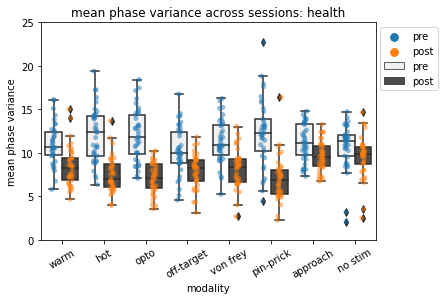

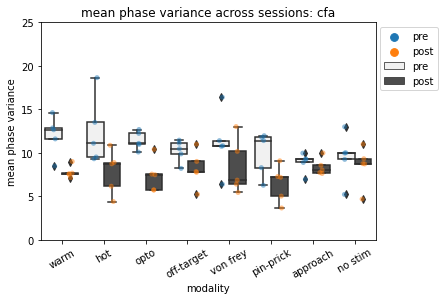

In [13]:
# COMPARE PRE TO POST STIMULUS SEPARATELY FOR HEALTH AND CFA DATASETS
# PHASE VARIANCE
phase_vars = pd.read_csv(os.path.join(output_path, 'phase variances pre_post.csv'), index_col=0)
health = phase_vars.loc[phase_vars['session'].str.contains('Ses')]
cfa = phase_vars.loc[phase_vars['session'].str.contains('CFA')]

ax = sns.stripplot(x="modality", y="mean phase variance", hue="pre/post", data=health, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase variance", hue="pre/post", data=health, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.ylim(0,25)
ax.set(title='mean phase variance across sessions: health')
plt.savefig(os.path.join(output_path, 'phase variance by session health.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="mean phase variance", hue="pre/post", data=cfa, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase variance", hue="pre/post", data=cfa, color='.3')
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.ylim(0,25)
ax.set(title='mean phase variance across sessions: cfa')
plt.savefig(os.path.join(output_path, 'phase variance by session cfa.png'), bbox_inches='tight')
plt.show()

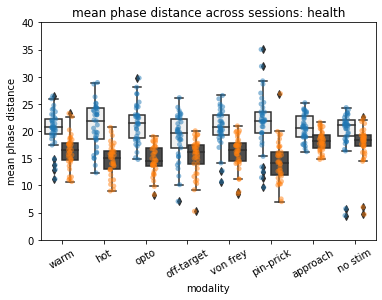

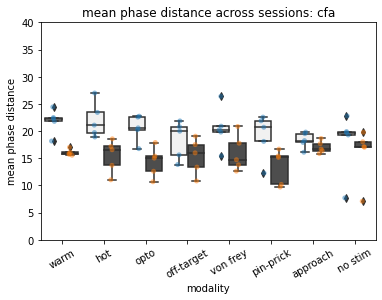

In [14]:
# PHASE DISTANCE
ax = sns.stripplot(x="modality", y="mean phase distance", hue="pre/post", data=health, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase distance", hue="pre/post", data=health, color='.3')
#ax.legend(bbox_to_anchor= (1.2,1))
ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.ylim(0,40)
ax.set(title='mean phase distance across sessions: health')
plt.savefig(os.path.join(output_path, 'phase distance by session health.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="mean phase distance", hue="pre/post", data=cfa, alpha=0.5, dodge=True)
ax = sns.boxplot(x="modality", y="mean phase distance", hue="pre/post", data=cfa, color='.3')
#ax.legend(bbox_to_anchor= (1.2,1))
ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.ylim(0,40)
ax.set(title='mean phase distance across sessions: cfa')
plt.savefig(os.path.join(output_path, 'phase distance by session cfa.png'), bbox_inches='tight')
plt.show()

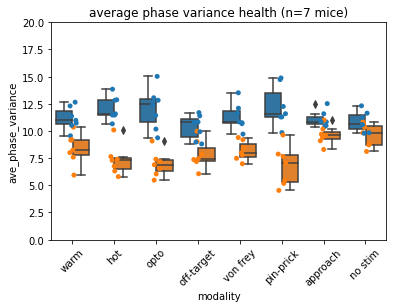

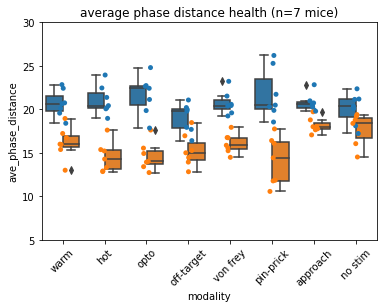

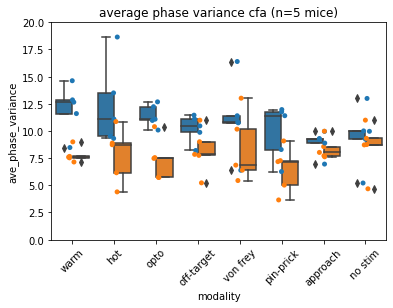

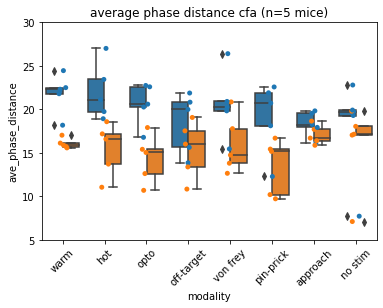

,mouse,modality,pre/post,ave_phase_variance,ave_phase_distance
0,2P07,warm,pre,8.473709,18.161758
1,2P07,warm,post,7.145287,15.865394
2,2P07,hot,pre,11.091844,21.090343
3,2P07,hot,post,4.396386,11.029848
4,2P07,opto,pre,10.084524,20.582607


In [15]:
# COMPUTE AVERAGE ACROSS SESSIONS FOR EACH MOUSE
stats_health = []
cols = ['mouse', 'modality', 'pre/post', 'ave_phase_variance', 'ave_phase_distance']
mice = ['2P05', '2P06', '2P07', '2P08', '2P09', '2P10', '2P11']
for m in mice:
    by_mouse = health[health['session'].str.contains(m)]
    for s in stimuli:
        pre = by_mouse[(by_mouse['modality']==s)&(by_mouse['pre/post']=='pre')]
        post = by_mouse[(by_mouse['modality']==s)&(by_mouse['pre/post']=='post')]
        var_pre = pre['mean phase variance'].mean()
        dist_pre = pre['mean phase distance'].mean()
        stats = [m, s, 'pre', var_pre, dist_pre]
        stats_health.append(stats)
        var_post = post['mean phase variance'].mean()
        dist_post = post['mean phase distance'].mean()
        stats = [m, s, 'post', var_post, dist_post]
        stats_health.append(stats)
    
stats_health = pd.DataFrame(stats_health, columns = cols)
#stats_health.to_csv(os.path.join(output_path, 'stats by mouse health 99 long.csv'))
ax = sns.stripplot(x='modality', y='ave_phase_variance', hue='pre/post', data=stats_health)
ax = sns.boxplot(x='modality', y='ave_phase_variance', hue='pre/post', data=stats_health)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(0, 20)
plt.title('average phase variance health (n=7 mice)')
plt.savefig(os.path.join(output_path, 'average phase variance health by mouse.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='ave_phase_distance', hue='pre/post', data=stats_health)
ax = sns.boxplot(x='modality', y='ave_phase_distance', hue='pre/post', data=stats_health)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(5, 30)
plt.title('average phase distance health (n=7 mice)')
plt.savefig(os.path.join(output_path, 'average phase distance health by mouse.png'), bbox_inches='tight')
plt.show()

stats_cfa = []
cols = ['mouse', 'modality', 'pre/post', 'ave_phase_variance', 'ave_phase_distance']
mice = ['2P07', '2P08', '2P09', '2P10', '2P11']
for m in mice:
    by_mouse = cfa[cfa['session'].str.contains(m)]
    for s in stimuli:
        pre = by_mouse[(by_mouse['modality']==s)&(by_mouse['pre/post']=='pre')]
        post = by_mouse[(by_mouse['modality']==s)&(by_mouse['pre/post']=='post')]
        var_pre = pre['mean phase variance'].mean()
        dist_pre = pre['mean phase distance'].mean()
        stats = [m, s, 'pre', var_pre, dist_pre]
        stats_cfa.append(stats)
        var_post = post['mean phase variance'].mean()
        dist_post = post['mean phase distance'].mean()
        stats = [m, s, 'post', var_post, dist_post]
        stats_cfa.append(stats)
    
stats_cfa = pd.DataFrame(stats_cfa, columns = cols)
#stats_cfa.to_csv(os.path.join(output_path, 'stats by mouse cfa 99 long.csv'))
ax = sns.stripplot(x='modality', y='ave_phase_variance',hue='pre/post', data=stats_cfa)
ax = sns.boxplot(x='modality', y='ave_phase_variance', hue='pre/post', data=stats_cfa)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(0, 20)
plt.title('average phase variance cfa (n=5 mice)')
plt.savefig(os.path.join(output_path, 'average phase variance cfa by mouse.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='ave_phase_distance', hue='pre/post', data=stats_cfa)
ax = sns.boxplot(x='modality', y='ave_phase_distance', hue='pre/post', data=stats_cfa)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(5, 30)
plt.title('average phase distance cfa (n=5 mice)')
plt.savefig(os.path.join(output_path, 'average phase distance cfa by mouse.png'), bbox_inches='tight')
plt.show()
stats_cfa.head()



In [15]:
stats_health.head()

,mouse,modality,pre/post,ave_phase_variance,ave_phase_distance
0,2P05,warm,pre,12.646221,22.826766
1,2P05,warm,post,8.005098,15.983498
2,2P05,hot,pre,12.864983,21.356264
3,2P05,hot,post,6.319396,12.896777
4,2P05,opto,pre,11.430658,22.404896


In [25]:
import pingouin as pg

pg.friedman(data=stats_health, dv="ave_phase_variance", within="pre/post", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,pre/post,1.0,1,7.0,0.008151


In [26]:
pg.friedman(data=stats_health, dv="ave_phase_distance", within="pre/post", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,pre/post,1.0,1,7.0,0.008151


In [27]:
pg.friedman(data=stats_cfa, dv="ave_phase_variance", within="pre/post", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,pre/post,1.0,1,5.0,0.025347


In [28]:
pg.friedman(data=stats_cfa, dv="ave_phase_distance", within="pre/post", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,pre/post,1.0,1,5.0,0.025347


In [36]:
#perform Nemenyi post-hoc test on health phase variance
for s in stimuli:
    pre_stim = stats_health.loc[(stats_health['modality']==s)&(stats_health['pre/post']=='pre')]['ave_phase_variance']
    post_stim = stats_health.loc[(stats_health['modality']==s)&(stats_health['pre/post']=='post')]['ave_phase_variance']
    data = np.array([pre_stim, post_stim])
    print(s, sp.posthoc_nemenyi_friedman(data.T))
    print('t-test', stats.ttest_rel(pre_stim, post_stim))

warm           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=4.239506680383533, pvalue=0.005442728720526383)
hot           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=6.998499456551216, pvalue=0.00042397611351396673)
opto           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=5.8032689704635585, pvalue=0.0011480741231854484)
off-target           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=5.157754778490294, pvalue=0.0020993158583976724)
von frey           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=8.350769331006445, pvalue=0.00016023311306496206)
pin-prick           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=7.554502562591374, pvalue=0.0002792297344490756)
approach           0         1
0  1.000000  0.008151
1  0.008151  

In [38]:
#perform Nemenyi post-hoc test on health phase distance
for s in stimuli:
    pre_stim = stats_health[(stats_health['modality']==s)&(stats_health['pre/post']=='pre')]['ave_phase_distance']
    post_stim = stats_health[(stats_health['modality']==s)&(stats_health['pre/post']=='post')]['ave_phase_distance']
    data = np.array([pre_stim, post_stim])
    print(s, sp.posthoc_nemenyi_friedman(data.T))
    print('t-test', stats.ttest_rel(pre_stim, post_stim))


warm           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=5.436588413369597, pvalue=0.0016075063693165594)
hot           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=8.15343429224071, pvalue=0.0001830805393146189)
opto           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=6.539878588526499, pvalue=0.0006109097028823978)
off-target           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=7.091734091882017, pvalue=0.000394566492570293)
von frey           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=10.74943892502952, pvalue=3.830380129842657e-05)
pin-prick           0         1
0  1.000000  0.008151
1  0.008151  1.000000
t-test Ttest_relResult(statistic=8.007322593304545, pvalue=0.0002024341024952763)
approach           0         1
0  1.000000  0.008151
1  0.008151  1.00

In [39]:
#perform Nemenyi post-hoc test on cfa phase variance
for s in stimuli:
    pre_stim = stats_cfa[(stats_cfa['modality']==s)&(stats_cfa['pre/post']=='pre')]['ave_phase_variance']
    post_stim = stats_cfa[(stats_cfa['modality']==s)&(stats_cfa['pre/post']=='post')]['ave_phase_variance']
    data = np.array([pre_stim, post_stim])
    print(s, sp.posthoc_nemenyi_friedman(data.T))
    print('t-test', stats.ttest_rel(pre_stim, post_stim))


warm           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=4.49302085957788, pvalue=0.010880578943676158)
hot           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=3.6329108809081534, pvalue=0.02210284636895249)
opto           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=6.369308987193784, pvalue=0.0031158915433724733)
off-target           0         1
0  1.000000  0.179714
1  0.179714  1.000000
t-test Ttest_relResult(statistic=2.875465725569041, pvalue=0.04521898411786791)
von frey           0         1
0  1.000000  0.179714
1  0.179714  1.000000
t-test Ttest_relResult(statistic=2.8979190250358524, pvalue=0.044210116915069375)
pin-prick           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=5.42239340540958, pvalue=0.0056080970035486365)
approach           0         1
0  1.000000  0.665646
1  0.665646  1.000000

In [40]:
#perform Nemenyi post-hoc test on cfa phase distance
for s in stimuli:
    pre_stim = stats_cfa[(stats_cfa['modality']==s)&(stats_cfa['pre/post']=='pre')]['ave_phase_distance']
    post_stim = stats_cfa[(stats_cfa['modality']==s)&(stats_cfa['pre/post']=='post')]['ave_phase_distance']
    data = np.array([pre_stim, post_stim])
    print(s, sp.posthoc_nemenyi_friedman(data.T))
    print('t-test', stats.ttest_rel(pre_stim, post_stim))



warm           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=5.55963786376729, pvalue=0.005124539677795434)
hot           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=5.0898928001535015, pvalue=0.007031982237579161)
opto           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=9.077335291432473, pvalue=0.0008165299024534465)
off-target           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=3.7815475890995223, pvalue=0.01940985943055213)
von frey           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=4.68766123808438, pvalue=0.009394052449569767)
pin-prick           0         1
0  1.000000  0.025345
1  0.025345  1.000000
t-test Ttest_relResult(statistic=6.474368228634681, pvalue=0.0029326780185631716)
approach           0         1
0  1.000000  0.665646
1  0.665646  1.00000

In [9]:
phase_vars = pd.read_csv(os.path.join(output_path, 'phase variances pre_post.csv'), index_col=0)
phase_vars.head()

,session,modality,pre/post,mean phase variance,mean phase distance
0,2P06_Ses01,warm,pre,12.274994,22.105924
1,2P06_Ses01,warm,post,10.051329,18.458336
2,2P06_Ses01,hot,pre,9.781513,19.817575
3,2P06_Ses01,hot,post,8.664389,16.415189
4,2P06_Ses01,opto,pre,11.527578,20.920703


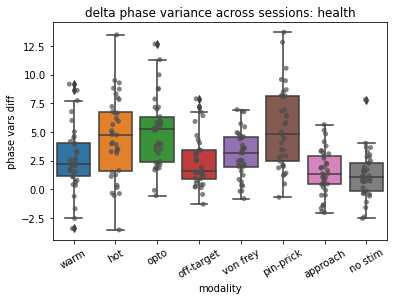

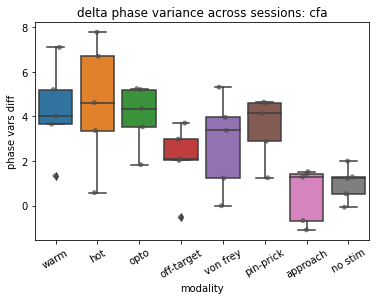

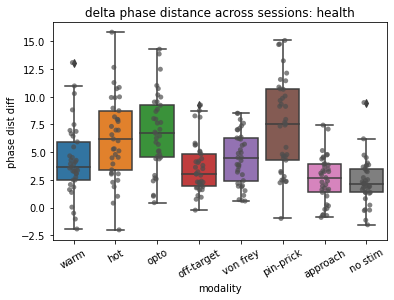

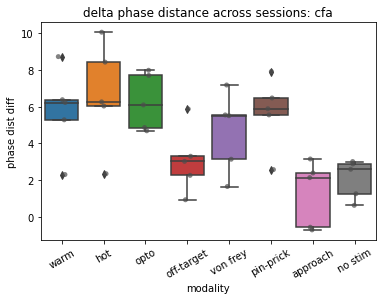

In [94]:
# calculate pre/post difference of phase variances and phase distances
vars_pre = np.array(phase_vars[phase_vars['pre/post']=='pre']['mean phase variance'])
vars_post = np.array(phase_vars[phase_vars['pre/post']=='post']['mean phase variance'])
var_diff = var_pre - var_post
phase_diffs = phase_vars_pre.drop(['pre/post'], axis=1)
phase_diffs['phase vars diff'] = var_diff
dist_pre = np.array(phase_vars[phase_vars['pre/post']=='pre']['mean phase distance'])
dist_post = np.array(phase_vars[phase_vars['pre/post']=='post']['mean phase distance'])
dist_diff = dist_pre - dist_post
phase_diffs['phase dist diff'] = dist_diff
phase_diffs = phase_diffs.drop(['mean phase variance','mean phase distance'], axis=1)
phase_diffs.to_csv(os.path.join(output_path, 'phase differences pre_post.csv'))

health = phase_diffs.loc[phase_diffs['session'].str.contains('Ses')]
cfa = phase_diffs.loc[phase_diffs ['session'].str.contains('CFA')]

ax = sns.stripplot(x="modality", y="phase vars diff", data=health, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase vars diff", data=health)
#ax.legend(bbox_to_anchor= (1.2,1))
ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase variance across sessions: health')
plt.savefig(os.path.join(output_path, 'delta phase variance by session health.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="phase vars diff", data=cfa, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase vars diff", data=cfa)
#ax.legend(bbox_to_anchor= (1.2,1))
ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase variance across sessions: cfa')
plt.savefig(os.path.join(output_path, 'delta phase variance by session cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="phase dist diff", data=health, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase dist diff", data=health)
#ax.legend(bbox_to_anchor= (1.2,1))
ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase distance across sessions: health')
plt.savefig(os.path.join(output_path, 'delta phase distance by session health.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="phase dist diff", data=cfa, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase dist diff", data=cfa)
#ax.legend(bbox_to_anchor= (1.2,1))
ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase distance across sessions: cfa')
plt.savefig(os.path.join(output_path, 'delta phase distance by session cfa.png'), bbox_inches='tight')
plt.show()

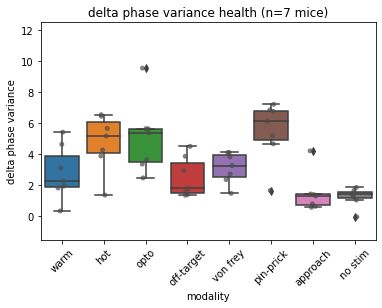

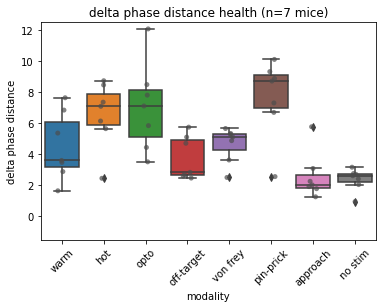

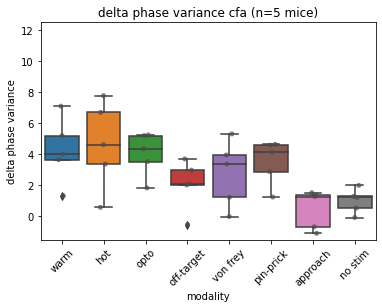

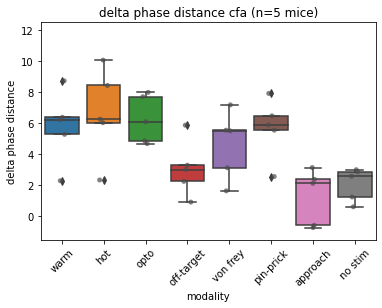

,mouse,modality,delta phase variance,delta phase distance
0,2P07,warm,1.328422,2.296364
1,2P07,hot,6.695458,10.060495
2,2P07,opto,4.350889,7.983820
3,2P07,off-target,2.979097,3.015711
4,2P07,von frey,-0.009489,1.643374


In [96]:
stats_health = []
cols = ['mouse', 'modality', 'delta phase variance', 'delta phase distance']
mice = ['2P05', '2P06', '2P07', '2P08', '2P09', '2P10', '2P11']
for m in mice:
    by_mouse = health[health['session'].str.contains(m)]
    for s in stimuli:
        delta_var = by_mouse[by_mouse['modality']==s]['phase vars diff'].mean()
        delta_dist = by_mouse[by_mouse['modality']==s]['phase dist diff'].mean()
        stats = [m, s, delta_var, delta_dist]
        stats_health.append(stats)
    
stats_health = pd.DataFrame(stats_health, columns = cols)
#stats_health.to_csv(os.path.join(output_path, 'stats by mouse health 99 long.csv'))
ax = sns.stripplot(x='modality', y='delta phase variance', data=stats_health, color='.3', alpha=0.7)
ax = sns.boxplot(x='modality', y='delta phase variance', data=stats_health)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(-1.5, 12.5)
plt.title('delta phase variance health (n=7 mice)')
plt.savefig(os.path.join(output_path, 'delta phase variance health by mouse.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='delta phase distance', data=stats_health, color='.3', alpha=0.7)
ax = sns.boxplot(x='modality', y='delta phase distance', data=stats_health)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(-1.5, 12.5)
plt.title('delta phase distance health (n=7 mice)')
plt.savefig(os.path.join(output_path, 'delta phase distance health by mouse.png'), bbox_inches='tight')
plt.show()

stats_cfa = []
cols = ['mouse', 'modality', 'delta phase variance', 'delta phase distance']
mice = ['2P07', '2P08', '2P09', '2P10', '2P11']
for m in mice:
    by_mouse = cfa[cfa['session'].str.contains(m)]
    for s in stimuli:
        delta_var = by_mouse[by_mouse['modality']==s]['phase vars diff'].mean()
        delta_dist = by_mouse[by_mouse['modality']==s]['phase dist diff'].mean()
        stats = [m, s, delta_var, delta_dist]
        stats_cfa.append(stats)
    
stats_cfa = pd.DataFrame(stats_cfa, columns = cols)
#stats_cfa.to_csv(os.path.join(output_path, 'stats by mouse cfa 99 long.csv'))
ax = sns.stripplot(x='modality', y='delta phase variance', data=stats_cfa, color='.3', alpha=0.7)
ax = sns.boxplot(x='modality', y='delta phase variance', data=stats_cfa)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(-1.5, 12.5)
plt.title('delta phase variance cfa (n=5 mice)')
plt.savefig(os.path.join(output_path, 'delta phase variance cfa by mouse.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x='modality', y='delta phase distance', data=stats_cfa, color='.3', alpha=0.7)
ax = sns.boxplot(x='modality', y='delta phase distance', data=stats_cfa)
plt.xticks(rotation=45)
ax.legend([],[], frameon=False)
plt.ylim(-1.5, 12.5)
plt.title('delta phase distance cfa (n=5 mice)')
plt.savefig(os.path.join(output_path, 'delta phase distance cfa by mouse.png'), bbox_inches='tight')
plt.show()
stats_cfa.head()




In [97]:
pg.friedman(data=stats_health, dv="delta phase variance", within="modality", subject='mouse')

,Source,W,ddof1,Q,p-unc
Friedman,modality,0.704568,7,34.52381,0.000014


In [98]:
sp.posthoc_conover_friedman(a=stats_health, y_col="delta phase variance", group_col="modality", block_col="mouse", 
                                 p_adjust="fdr_bh", melted=True)

,warm,hot,opto,off-target,von frey,pin-prick,approach,no stim
warm,1.000000,0.137206,0.128607,0.867472,0.707425,0.075264,0.307529,0.221989
hot,0.137206,1.000000,0.917795,0.111961,0.271591,0.707425,0.015445,0.009654
opto,0.128607,0.917795,1.000000,0.108487,0.252766,0.761609,0.013903,0.009535
off-target,0.867472,0.111961,0.108487,1.000000,0.599905,0.051781,0.406732,0.271591
von frey,0.707425,0.271591,0.252766,0.599905,1.000000,0.137206,0.158297,0.111961
pin-prick,0.075264,0.707425,0.761609,0.051781,0.137206,1.000000,0.009535,0.008311
approach,0.307529,0.015445,0.013903,0.406732,0.158297,0.009535,1.000000,0.815186
no stim,0.221989,0.009654,0.009535,0.271591,0.111961,0.008311,0.815186,1.000000


In [99]:
#perform Nemenyi post-hoc test on health delta phase variance
warm = stats_health[stats_health['modality']=='warm']['delta phase variance']
hot = stats_health[stats_health['modality']=='hot']['delta phase variance']
off_target = stats_health[stats_health['modality']=='off-target']['delta phase variance']
von_frey = stats_health[stats_health['modality']=='von frey']['delta phase variance']
pin_prick = stats_health[stats_health['modality']=='pin-prick']['delta phase variance']
approach = stats_health[stats_health['modality']=='approach']['delta phase variance']
opto = stats_health[stats_health['modality']=='opto']['delta phase variance']
no_stim = stats_health[stats_health['modality']=='no stim']['delta phase variance']

stat, p = friedmanchisquare(warm, hot, off_target, von_frey, pin_prick, approach, opto, no_stim)
print('friedmans delta phase variance health: ', stat, p)

mechanical_data = np.array([von_frey, pin_prick, approach])
print('post hoc mechanical: ', sp.posthoc_nemenyi_friedman(mechanical_data.T))
      
thermal_data = np.array([warm, hot, off_target])
print('post hoc thermal: ', sp.posthoc_nemenyi_friedman(thermal_data.T))
      
opto_data = np.array([opto, no_stim])
print('post hoc thermal: ', sp.posthoc_nemenyi_friedman(opto_data.T))



friedmans delta phase variance health:  34.52380952380952 1.3740954675204095e-05
post hoc mechanical:            0         1         2
0  1.000000  0.082380  0.376245
1  0.082380  1.000000  0.001488
2  0.376245  0.001488  1.000000
post hoc thermal:            0         1         2
0  1.000000  0.082380  0.837739
1  0.082380  1.000000  0.020573
2  0.837739  0.020573  1.000000
post hoc thermal:            0         1
0  1.000000  0.008151
1  0.008151  1.000000


In [100]:
pg.friedman(data=stats_health, dv="delta phase distance", within="modality", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,modality,0.708455,7,34.714286,0.000013


In [101]:
#perform Nemenyi post-hoc test on health delta phase distance
warm = stats_health[stats_health['modality']=='warm']['delta phase distance']
hot = stats_health[stats_health['modality']=='hot']['delta phase distance']
off_target = stats_health[stats_health['modality']=='off-target']['delta phase distance']
von_frey = stats_health[stats_health['modality']=='von frey']['delta phase distance']
pin_prick = stats_health[stats_health['modality']=='pin-prick']['delta phase distance']
approach = stats_health[stats_health['modality']=='approach']['delta phase distance']
opto = stats_health[stats_health['modality']=='opto']['delta phase distance']
no_stim = stats_health[stats_health['modality']=='no stim']['delta phase distance']

stat, p = friedmanchisquare(warm, hot, off_target, von_frey, pin_prick, approach, opto, no_stim)
print('friedmans delta phase distance health: ', stat, p)

mechanical_data = np.array([von_frey, pin_prick, approach])
print('post hoc mechanical: ', sp.posthoc_nemenyi_friedman(mechanical_data.T))
      
thermal_data = np.array([warm, hot, off_target])
print('post hoc thermal: ', sp.posthoc_nemenyi_friedman(thermal_data.T))
      
opto_data = np.array([opto, no_stim])
print('post hoc thermal: ', sp.posthoc_nemenyi_friedman(opto_data.T))



friedmans delta phase distance health:  34.714285714285694 1.2655440778860575e-05
post hoc mechanical:            0         1         2
0  1.000000  0.082380  0.376245
1  0.082380  1.000000  0.001488
2  0.376245  0.001488  1.000000
post hoc thermal:            0         1         2
0  1.000000  0.082380  0.837739
1  0.082380  1.000000  0.020573
2  0.837739  0.020573  1.000000
post hoc thermal:            0         1
0  1.000000  0.008151
1  0.008151  1.000000


In [102]:
#perform Nemenyi post-hoc test on cfa delta phase variance
warm = stats_cfa[stats_cfa['modality']=='warm']['delta phase variance']
hot = stats_cfa[stats_cfa['modality']=='hot']['delta phase variance']
off_target = stats_cfa[stats_cfa['modality']=='off-target']['delta phase variance']
von_frey = stats_cfa[stats_cfa['modality']=='von frey']['delta phase variance']
pin_prick = stats_cfa[stats_cfa['modality']=='pin-prick']['delta phase variance']
approach = stats_cfa[stats_cfa['modality']=='approach']['delta phase variance']
opto = stats_cfa[stats_cfa['modality']=='opto']['delta phase variance']
no_stim = stats_cfa[stats_cfa['modality']=='no stim']['delta phase variance']

stat, p = friedmanchisquare(warm, hot, off_target, von_frey, pin_prick, approach, opto, no_stim)
print('friedmans delta phase variance cfa: ', stat, p)

mechanical_data = np.array([von_frey, pin_prick, approach])
print('post hoc mechanical: ', sp.posthoc_nemenyi_friedman(mechanical_data.T))
      
thermal_data = np.array([warm, hot, off_target])
print('post hoc thermal: ', sp.posthoc_nemenyi_friedman(thermal_data.T))
      
opto_data = np.array([opto, no_stim])
print('post hoc thermal: ', sp.posthoc_nemenyi_friedman(opto_data.T))

friedmans delta phase variance cfa:  15.933333333333337 0.0257324650997028
post hoc mechanical:            0         1         2
0  1.000000  0.900000  0.139445
1  0.900000  1.000000  0.139445
2  0.139445  0.139445  1.000000
post hoc thermal:            0         1         2
0  1.000000  0.781714  0.254114
1  0.781714  1.000000  0.068941
2  0.254114  0.068941  1.000000
post hoc thermal:            0         1
0  1.000000  0.179714
1  0.179714  1.000000


In [103]:
#perform Nemenyi post-hoc test on cfa delta phase distance
warm = stats_cfa[stats_cfa['modality']=='warm']['delta phase distance']
hot = stats_cfa[stats_cfa['modality']=='hot']['delta phase distance']
off_target = stats_cfa[stats_cfa['modality']=='off-target']['delta phase distance']
von_frey = stats_cfa[stats_cfa['modality']=='von frey']['delta phase distance']
pin_prick = stats_cfa[stats_cfa['modality']=='pin-prick']['delta phase distance']
approach = stats_cfa[stats_cfa['modality']=='approach']['delta phase distance']
opto = stats_cfa[stats_cfa['modality']=='opto']['delta phase distance']
no_stim = stats_cfa[stats_cfa['modality']=='no stim']['delta phase distance']

stat, p = friedmanchisquare(warm, hot, off_target, von_frey, pin_prick, approach, opto, no_stim)
print('friedmans delta phase variance cfa: ', stat, p)

mechanical_data = np.array([von_frey, pin_prick, approach])
print('post hoc mechanical: ', sp.posthoc_nemenyi_friedman(mechanical_data.T))
      
thermal_data = np.array([warm, hot, off_target])
print('post hoc thermal: ', sp.posthoc_nemenyi_friedman(thermal_data.T))
      
opto_data = np.array([opto, no_stim])
print('post hoc opto: ', sp.posthoc_nemenyi_friedman(opto_data.T))

friedmans delta phase variance cfa:  18.066666666666663 0.01167280914647214
post hoc mechanical:            0         1         2
0  1.000000  0.600820  0.139445
1  0.600820  1.000000  0.012315
2  0.139445  0.012315  1.000000
post hoc thermal:            0         1         2
0  1.000000  0.900000  0.139445
1  0.900000  1.000000  0.139445
2  0.139445  0.139445  1.000000
post hoc thermal:            0         1
0  1.000000  0.025345
1  0.025345  1.000000


In [5]:
phase_diffs.head()

,session,modality,phase vars diff,phase dist diff
0,2P06_Ses01,warm,2.223665,3.647588
2,2P06_Ses01,hot,1.117125,3.402385
4,2P06_Ses01,opto,2.141677,2.577453
6,2P06_Ses01,off-target,-0.452204,1.079444
8,2P06_Ses01,von frey,1.977584,3.840664


In [29]:
# COMPARE PHASE VARIANCE/DIFFERENCE BETWEEN HEALTH LAST SESSION & CFA
phase_diffs = pd.read_csv('/Volumes/Behaviour/Tailored 3sec 2P Trials/Phase Synchronization/phase differences pre_post.csv', index_col=0)
last_session = ['2P07_Ses07', '2P08_Ses06', '2P09_Ses05', '2P10_Ses05', '2P11_Ses06']
df = phase_diffs[phase_diffs['session'].str.contains('CFA')|phase_diffs['session'].isin(last_session)]
df['mouse'] = df['session'].apply(lambda x: x[:4])
df['cfa'] = df['session'].apply(lambda x: 'cfa' if 'CFA' in x else 'health')

phase_diffs.head()

/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/aspra/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,session,modality,phase vars diff,phase dist diff
0,2P06_Ses01,warm,2.223665,3.647588
2,2P06_Ses01,hot,1.117125,3.402385
4,2P06_Ses01,opto,2.141677,2.577453
6,2P06_Ses01,off-target,-0.452204,1.079444
8,2P06_Ses01,von frey,1.977584,3.840664


In [30]:
pg.friedman(data=df, dv="phase dist diff", within="modality", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,modality,0.731429,7,25.6,0.000594


In [31]:
pg.friedman(data=df, dv="phase dist diff", within="cfa", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,cfa,0.36,1,1.8,0.179712


In [32]:
pg.friedman(data=df, dv="phase vars diff", within="modality", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,modality,0.657143,7,23.0,0.001705


In [33]:
pg.friedman(data=df, dv="phase vars diff", within="cfa", subject="mouse")

,Source,W,ddof1,Q,p-unc
Friedman,cfa,0.04,1,0.2,0.654721


In [9]:
df.to_csv(os.path.join(output_path, 'lastSession_CFA_for_ANOVA.csv'))

In [8]:
df.head()

,session,modality,phase vars diff,phase dist diff,mouse,cfa
304,2P07_Ses07,warm,2.741800,3.920986,2P07,health
306,2P07_Ses07,hot,0.339430,1.871322,2P07,health
308,2P07_Ses07,opto,-0.098387,0.437474,2P07,health
310,2P07_Ses07,off-target,3.139079,3.509863,2P07,health
312,2P07_Ses07,von frey,-0.177606,1.092469,2P07,health


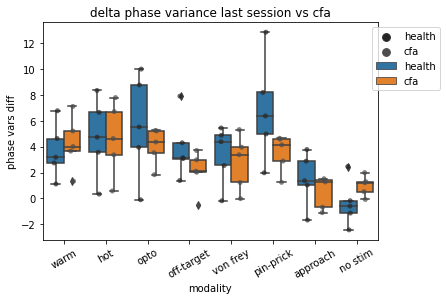

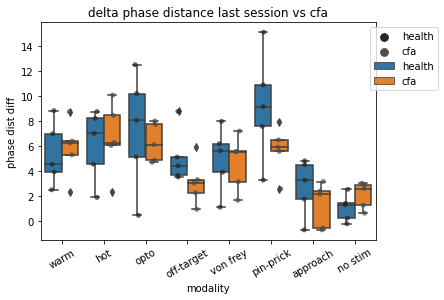

In [34]:
# Plot delta phase variance/distance for health (last session) & cfa
ax = sns.stripplot(x="modality", y="phase vars diff", hue='cfa', data=df, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase vars diff", hue='cfa', data=df)
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase variance last session vs cfa')
plt.savefig(os.path.join(output_path, 'delta phase variance last session vs cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="phase dist diff", hue='cfa', data=df, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase dist diff", hue='cfa', data=df)
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase distance last session vs cfa')
plt.savefig(os.path.join(output_path, 'delta phase distance last session vs cfa.png'), bbox_inches='tight')
plt.show()

In [35]:
#perform Nemenyi post-hoc test on health last session vs cfa delta phase variance
warm_h = df.loc[(df['modality']=='warm') & (df['cfa']=='health')]['phase vars diff']
hot_h = df.loc[(df['modality']=='hot') & (df['cfa']=='health')]['phase vars diff']
off_target_h = df.loc[(df['modality']=='off-target') & (df['cfa']=='health')]['phase vars diff']
von_frey_h = df.loc[(df['modality']=='von frey') & (df['cfa']=='health')]['phase vars diff']
pin_prick_h = df.loc[(df['modality']=='pin-prick') & (df['cfa']=='health')]['phase vars diff']
approach_h = df.loc[(df['modality']=='approach') & (df['cfa']=='health')]['phase vars diff']
opto_h = df.loc[(df['modality']=='opto') & (df['cfa']=='health')]['phase vars diff']
no_stim_h = df.loc[(df['modality']=='no stim') & (df['cfa']=='health')]['phase vars diff']

warm_c = df.loc[(df['modality']=='warm') & (df['cfa']=='cfa')]['phase vars diff']
hot_c = df.loc[(df['modality']=='hot') & (df['cfa']=='cfa')]['phase vars diff']
off_target_c = df.loc[(df['modality']=='off-target') & (df['cfa']=='cfa')]['phase vars diff']
von_frey_c = df.loc[(df['modality']=='von frey') & (df['cfa']=='cfa')]['phase vars diff']
pin_prick_c = df.loc[(df['modality']=='pin-prick') & (df['cfa']=='cfa')]['phase vars diff']
approach_c = df.loc[(df['modality']=='approach') & (df['cfa']=='cfa')]['phase vars diff']
opto_c = df.loc[(df['modality']=='opto') & (df['cfa']=='cfa')]['phase vars diff']
no_stim_c = df.loc[(df['modality']=='no stim') & (df['cfa']=='cfa')]['phase vars diff']

von_frey = np.array([von_frey_h, von_frey_c])
print('post hoc von frey: ', sp.posthoc_nemenyi_friedman(von_frey.T))
      
pin_prick = np.array([pin_prick_h, pin_prick_c])
print('post hoc pin-prick: ', sp.posthoc_nemenyi_friedman(pin_prick.T))

approach = np.array([approach_h, approach_c])
print('post hoc approach: ', sp.posthoc_nemenyi_friedman(approach.T))

warm = np.array([warm_h, warm_c])
print('post hoc warm: ', sp.posthoc_nemenyi_friedman(warm.T))

hot = np.array([hot_h, hot_c])
print('post hoc hot: ', sp.posthoc_nemenyi_friedman(hot.T))

off_target = np.array([off_target_h, off_target_c])
print('post hoc off target: ', sp.posthoc_nemenyi_friedman(off_target.T))

opto = np.array([opto_h, opto_c])
print('post hoc opto: ', sp.posthoc_nemenyi_friedman(opto.T))

no_stim = np.array([no_stim_h, no_stim_c])
print('post hoc no stim: ', sp.posthoc_nemenyi_friedman(no_stim.T))

post hoc von frey:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc pin-prick:            0         1
0  1.000000  0.179714
1  0.179714  1.000000
post hoc approach:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc warm:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc hot:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc off target:            0         1
0  1.000000  0.179714
1  0.179714  1.000000
post hoc opto:            0         1
0  1.000000  0.179714
1  0.179714  1.000000
post hoc no stim:            0         1
0  1.000000  0.179714
1  0.179714  1.000000


In [36]:
# Non-parametric paired t-test for each modality pair: phase variance health (last session) vs cfa
from scipy.stats import wilcoxon

d = np.array(warm_h) - np.array(warm_c)
res = wilcoxon(d)
print('warm delta phase variance: ', res.statistic, res.pvalue)

d = np.array(hot_h) - np.array(hot_c)
res = wilcoxon(d)
print('hot delta phase variance: ', res.statistic, res.pvalue)

d = np.array(off_target_h) - np.array(off_target_c)
res = wilcoxon(d)
print('off target delta phase variance: ', res.statistic, res.pvalue)

d = np.array(von_frey_h) - np.array(von_frey_c)
res = wilcoxon(d)
print('von frey delta phase variance: ', res.statistic, res.pvalue)

d = np.array(pin_prick_h) - np.array(pin_prick_c)
res = wilcoxon(d)
print('pin-prick delta phase variance: ', res.statistic, res.pvalue)

d = np.array(approach_h) - np.array(approach_c)
res = wilcoxon(d)
print('approach delta phase variance: ', res.statistic, res.pvalue)

d = np.array(opto_h) - np.array(opto_c)
res = wilcoxon(d)
print('opto delta phase variance: ', res.statistic, res.pvalue)

d = np.array(no_stim_h) - np.array(no_stim_c)
res = wilcoxon(d)
print('no stimulation delta phase variance: ', res.statistic, res.pvalue)

warm delta phase variance:  5.0 0.625
hot delta phase variance:  7.0 1.0
off target delta phase variance:  2.0 0.1875
von frey delta phase variance:  6.0 0.8125
pin-prick delta phase variance:  1.0 0.125
approach delta phase variance:  6.0 0.8125
opto delta phase variance:  4.0 0.4375
no stimulation delta phase variance:  2.0 0.1875


In [37]:
#perform Nemenyi post-hoc test on health last session vs cfa delta phase distance
warm_h = df.loc[(df['modality']=='warm') & (df['cfa']=='health')]['phase dist diff']
hot_h = df.loc[(df['modality']=='hot') & (df['cfa']=='health')]['phase dist diff']
off_target_h = df.loc[(df['modality']=='off-target') & (df['cfa']=='health')]['phase dist diff']
von_frey_h = df.loc[(df['modality']=='von frey') & (df['cfa']=='health')]['phase dist diff']
pin_prick_h = df.loc[(df['modality']=='pin-prick') & (df['cfa']=='health')]['phase dist diff']
approach_h = df.loc[(df['modality']=='approach') & (df['cfa']=='health')]['phase dist diff']
opto_h = df.loc[(df['modality']=='opto') & (df['cfa']=='health')]['phase dist diff']
no_stim_h = df.loc[(df['modality']=='no stim') & (df['cfa']=='health')]['phase dist diff']

warm_c = df.loc[(df['modality']=='warm') & (df['cfa']=='cfa')]['phase dist diff']
hot_c = df.loc[(df['modality']=='hot') & (df['cfa']=='cfa')]['phase dist diff']
off_target_c = df.loc[(df['modality']=='off-target') & (df['cfa']=='cfa')]['phase dist diff']
von_frey_c = df.loc[(df['modality']=='von frey') & (df['cfa']=='cfa')]['phase dist diff']
pin_prick_c = df.loc[(df['modality']=='pin-prick') & (df['cfa']=='cfa')]['phase dist diff']
approach_c = df.loc[(df['modality']=='approach') & (df['cfa']=='cfa')]['phase dist diff']
opto_c = df.loc[(df['modality']=='opto') & (df['cfa']=='cfa')]['phase dist diff']
no_stim_c = df.loc[(df['modality']=='no stim') & (df['cfa']=='cfa')]['phase dist diff']

von_frey = np.array([von_frey_h, von_frey_c])
print('post hoc von frey: ', sp.posthoc_nemenyi_friedman(von_frey.T))
      
pin_prick = np.array([pin_prick_h, pin_prick_c])
print('post hoc pin-prick: ', sp.posthoc_nemenyi_friedman(pin_prick.T))

approach = np.array([approach_h, approach_c])
print('post hoc approach: ', sp.posthoc_nemenyi_friedman(approach.T))

warm = np.array([warm_h, warm_c])
print('post hoc warm: ', sp.posthoc_nemenyi_friedman(warm.T))

hot = np.array([hot_h, hot_c])
print('post hoc hot: ', sp.posthoc_nemenyi_friedman(hot.T))

off_target = np.array([off_target_h, off_target_c])
print('post hoc off target: ', sp.posthoc_nemenyi_friedman(off_target.T))

opto = np.array([opto_h, opto_c])
print('post hoc opto: ', sp.posthoc_nemenyi_friedman(opto.T))

no_stim = np.array([no_stim_h, no_stim_c])
print('post hoc no stim: ', sp.posthoc_nemenyi_friedman(no_stim.T))

post hoc von frey:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc pin-prick:            0         1
0  1.000000  0.179714
1  0.179714  1.000000
post hoc approach:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc warm:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc hot:            0         1
0  1.000000  0.665646
1  0.665646  1.000000
post hoc off target:            0         1
0  1.000000  0.025345
1  0.025345  1.000000
post hoc opto:            0         1
0  1.000000  0.179714
1  0.179714  1.000000
post hoc no stim:            0         1
0  1.000000  0.179714
1  0.179714  1.000000


In [38]:
# Non-parametric paired t-test for each modality pair: phase distance health (last session) vs cfa
from scipy.stats import wilcoxon

d = np.array(warm_h) - np.array(warm_c)
res = wilcoxon(d)
print('warm delta phase distance: ', res.statistic, res.pvalue)

d = np.array(hot_h) - np.array(hot_c)
res = wilcoxon(d)
print('hot delta phase distance: ', res.statistic, res.pvalue)

d = np.array(off_target_h) - np.array(off_target_c)
res = wilcoxon(d)
print('off target delta phase distance: ', res.statistic, res.pvalue)

d = np.array(von_frey_h) - np.array(von_frey_c)
res = wilcoxon(d)
print('von frey delta phase distance: ', res.statistic, res.pvalue)

d = np.array(pin_prick_h) - np.array(pin_prick_c)
res = wilcoxon(d)
print('pin-prick delta phase distance: ', res.statistic, res.pvalue)

d = np.array(approach_h) - np.array(approach_c)
res = wilcoxon(d)
print('approach delta phase distance: ', res.statistic, res.pvalue)

d = np.array(opto_h) - np.array(opto_c)
res = wilcoxon(d)
print('opto delta phase distance: ', res.statistic, res.pvalue)

d = np.array(no_stim_h) - np.array(no_stim_c)
res = wilcoxon(d)
print('no stimulation delta phase distance: ', res.statistic, res.pvalue)

warm delta phase distance:  6.0 0.8125
hot delta phase distance:  7.0 1.0
off target delta phase distance:  0.0 0.0625
von frey delta phase distance:  7.0 1.0
pin-prick delta phase distance:  1.0 0.125
approach delta phase distance:  4.0 0.4375
opto delta phase distance:  5.0 0.625
no stimulation delta phase distance:  2.0 0.1875


In [41]:
# COPMARE PHASE METRICS BETWEEN HEALTH AND CFA AGAIN, THIS TIME KEEPING ALL HEALTH SESSIONS
phase_diffs['mouse'] = phase_diffs['session'].apply(lambda x: x[:4])
phase_diffs['cfa'] = phase_diffs['session'].apply(lambda x: 'cfa' if 'CFA' in x else 'health')

phase_diffs.head()


,session,modality,phase vars diff,phase dist diff,mouse,cfa
0,2P06_Ses01,warm,2.223665,3.647588,2P06,health
2,2P06_Ses01,hot,1.117125,3.402385,2P06,health
4,2P06_Ses01,opto,2.141677,2.577453,2P06,health
6,2P06_Ses01,off-target,-0.452204,1.079444,2P06,health
8,2P06_Ses01,von frey,1.977584,3.840664,2P06,health


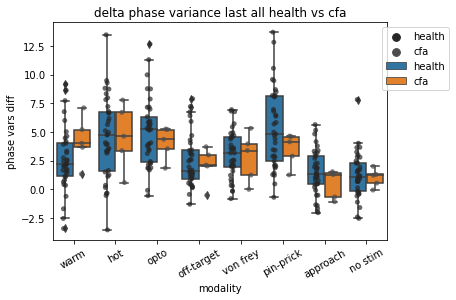

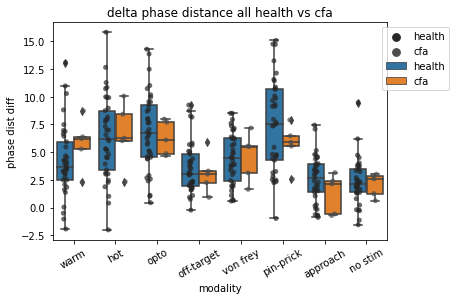

In [43]:
# Plot delta phase variance/distance for health (all sessions) & cfa
ax = sns.stripplot(x="modality", y="phase vars diff", hue='cfa', data=phase_diffs, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase vars diff", hue='cfa', data=phase_diffs)
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase variance last all health vs cfa')
plt.savefig(os.path.join(output_path, 'delta phase variance last all health vs cfa.png'), bbox_inches='tight')
plt.show()

ax = sns.stripplot(x="modality", y="phase dist diff", hue='cfa', data=phase_diffs, color='.3', alpha=0.7, dodge=True)
ax = sns.boxplot(x="modality", y="phase dist diff", hue='cfa', data=phase_diffs)
ax.legend(bbox_to_anchor= (1.2,1))
#ax.legend([],[], frameon=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
#plt.ylim(0,25)
ax.set(title='delta phase distance all health vs cfa')
plt.savefig(os.path.join(output_path, 'delta phase distance all health vs cfa.png'), bbox_inches='tight')
plt.show()